In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import koopman_dir as km
from load_dataset import *
import argparse

import os
import yaml
import matplotlib.pyplot as plt

['/home/shiqi/code/model_combination_Argos/combined_network_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [2]:
import yaml

config_path = 'config_linear_1000_20.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
save_dir = config['save_dir']
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
data_dir = config['data_dir']
# data_dir = '../data'
x_dataset = []
u_dataset = []
window_size = config['window_size']


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if data_file_path.endswith('.npy') and os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[:window_size])
        u_dataset.append(u_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

x_data = np.concatenate(x_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)

In [5]:
x_data.shape, u_data.shape

((7350, 6957), (7350, 2))

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 假设 x_data 已经是你的数据
# x_data.shape = (7350, 6957)

# 标准化数据
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)


In [7]:
x_scaled.shape

(7350, 6957)

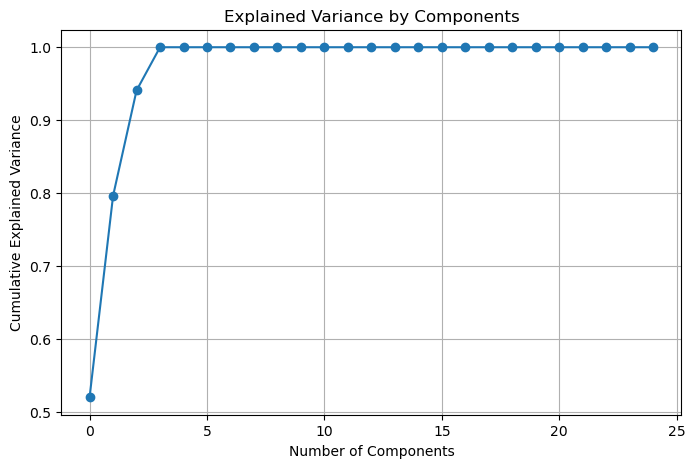

In [8]:
# 初始化PCA
pca = PCA(n_components=25)  # 选择一个初始的维度数目，例如100
x_pca = pca.fit_transform(x_scaled)

# 解释的方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 可视化累积解释方差
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# plt.yscale('log')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


In [9]:
cumulative_explained_variance

array([0.52025087, 0.79624178, 0.9407649 , 0.99999469, 0.99999705,
       0.99999787, 0.99999852, 0.99999913, 0.99999937, 0.99999952,
       0.99999966, 0.99999975, 0.99999981, 0.99999986, 0.99999989,
       0.99999991, 0.99999993, 0.99999994, 0.99999995, 0.99999996,
       0.99999996, 0.99999997, 0.99999997, 0.99999998, 0.99999998])

In [10]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 假设 x_data 是你的原始数据
# x_data.shape = (7350, 6957)

# 首先，标准化数据
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)

# 使用PCA降维到5维
pca = PCA(n_components=10)
x_pca = pca.fit_transform(x_scaled)
print(f"PCA降维后的数据维度: {x_pca.shape}")

# 使用PCA的逆变换重构数据
x_reconstructed = pca.inverse_transform(x_pca)

# 计算重构误差
reconstruction_error = mean_squared_error(x_scaled, x_reconstructed)

print(f"重构误差（MSE）: {reconstruction_error}")


PCA降维后的数据维度: (7350, 10)
重构误差（MSE）: 4.806387052601249e-07


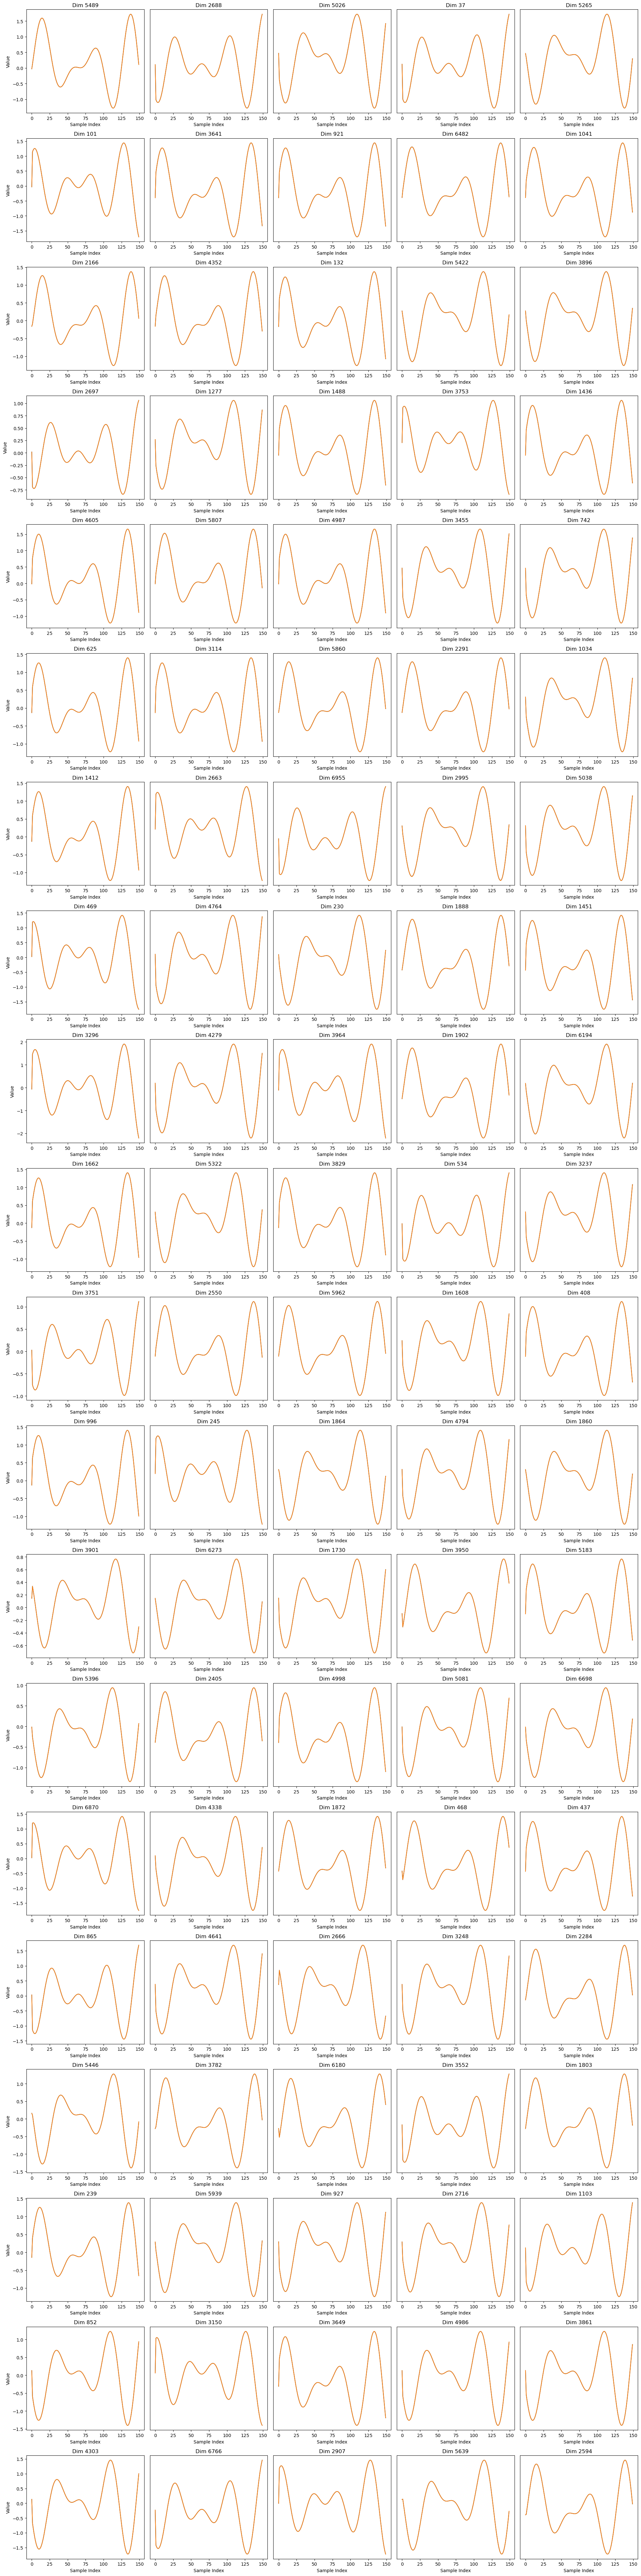

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 随机选择100个维度
np.random.seed(42)  # 确保随机选取是可重复的
selected_dimensions = np.random.choice(x_data.shape[1], 100, replace=False)

# 设置图像大小和布局
plt.figure(figsize=(20, 80))  # 根据需要调整图像大小

k = 10
# 绘制每个维度的前150个数据
for i, dim in enumerate(selected_dimensions):
    plt.subplot(20, 5, i + 1)  # 20行，每行5个图
    plt.plot(x_scaled[k*150:(k+1)*150, dim])
    plt.plot(x_reconstructed[k*150:(k+1)*150, dim])
    plt.title(f"Dim {dim}")
    plt.xlabel("Sample Index")
    if i % 5 == 0:  # 只在每行的第一个小图显示y轴标签
        plt.ylabel("Value")
    else:
        plt.yticks([])  # 隐藏其他小图的y轴标签

plt.tight_layout()
plt.show()


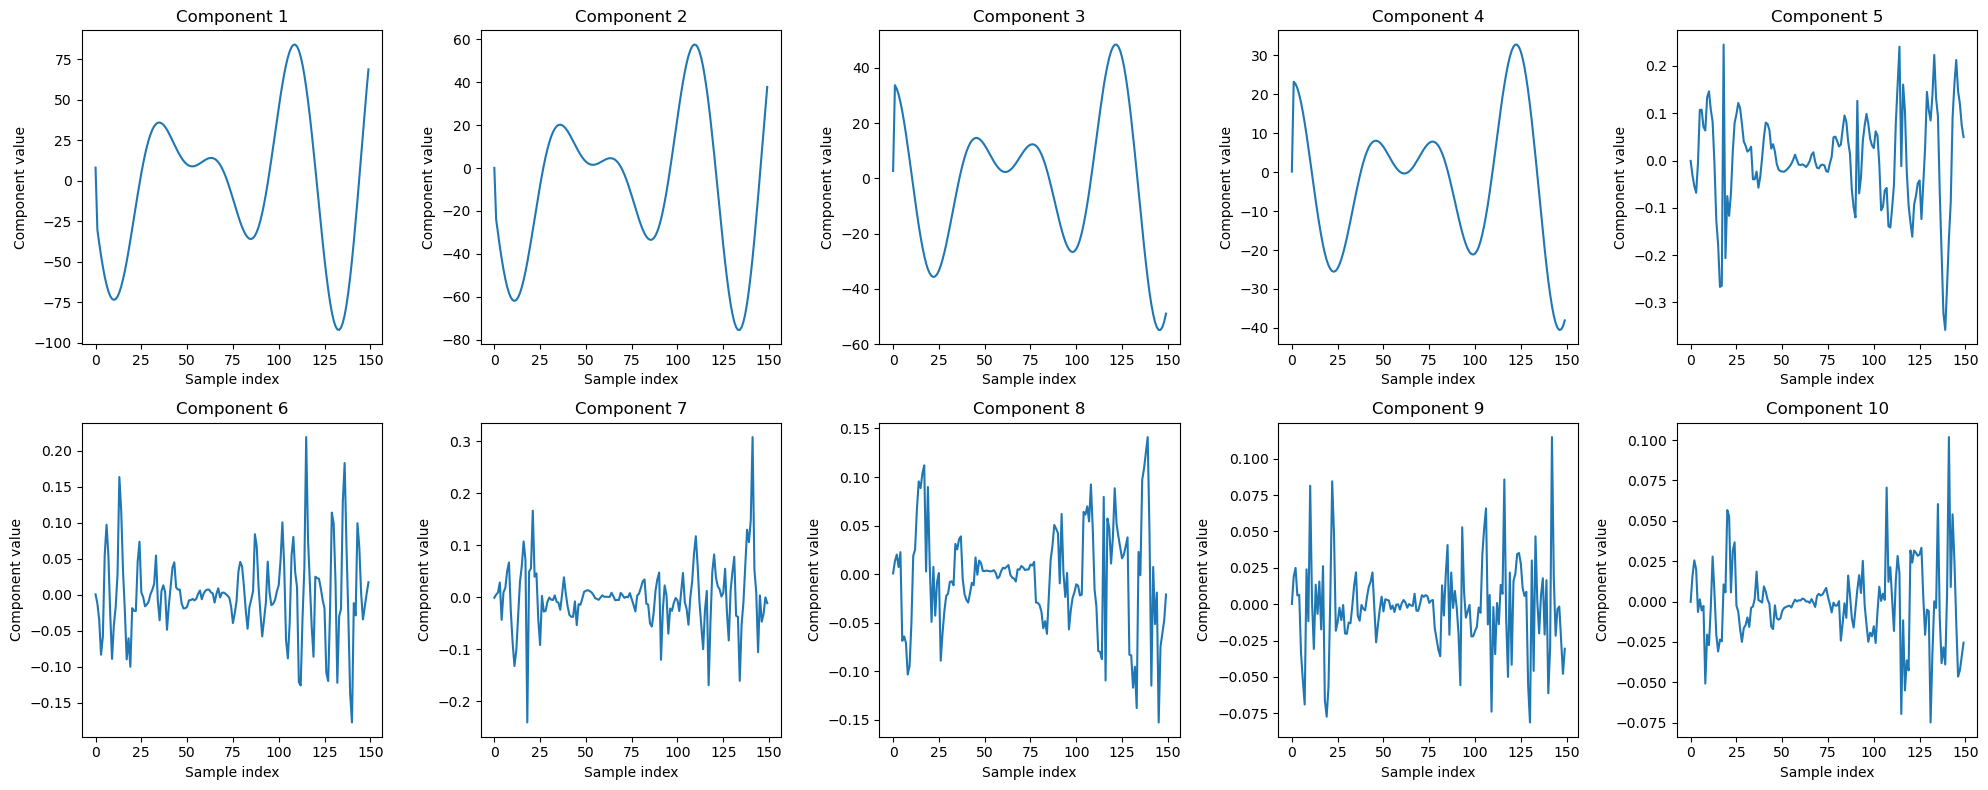

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plotting the first 150 samples of each PCA component in a row of 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(10):
    row = i // 5  # Determining the row of the subplot
    col = i % 5   # Determining the column of the subplot
    axes[row, col].plot(x_pca[:150, i])  # Corrected to plot with dots for clarity
    axes[row, col].set_title(f'Component {i+1}')
    axes[row, col].set_xlabel('Sample index')
    axes[row, col].set_ylabel('Component value')

plt.tight_layout()
plt.show()


In [13]:
x_pca.shape

(7350, 10)